In [6]:
#### ------------------------------------------------------------------------------------------
#### author: Ranjan Barman, date: Mar 6, 2025
#### Compute 12NPIFs based on HoverNet prediction, using MPP = 0.248 for unit conversion
#### Removes outliers for Major Axis and Minor Axis using IQR
#### Filters top 25% tiles based on majority of cancer nuclei
#### ------------------------------------------------------------------------------------------

import os
import pandas as pd
import numpy as np

# Set working directory
_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.makedirs(_wpath_, exist_ok=True)
os.chdir(_wpath_)

print("Working directory:", _wpath_)

# Define dataset name and output file path dynamically
dataset_name = "CPTAC_BRCA"
input_folder = f"{dataset_name}/HoverNet/outputs/"
output_file_path = f"{dataset_name}/HoverNet/outputs/CPTAC_BRCA_HoverNet_NPIFs_Filtered_Tiles_Top25Q.csv"

# Define column names for computation
columns_to_compute = ["Area", "Major Axis", "Minor Axis", "Perimeter", "Eccentricity", "Circularity"]

# Define MPP for conversion
MPP = 0.248  

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Store results in a list
results = []

# Get all folders matching CPTAC pattern
cptac_folders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f)) and f.endswith("_tiles")]

# Process each detected CPTAC folder
for slide_name in cptac_folders:
    file_path = os.path.join(input_folder, slide_name, "features", f"{slide_name}.csv")
    
    # Check if file exists before proceeding
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}, skipping...")
        continue

    # Load CSV file
    df = pd.read_csv(file_path)

    # Convert units using MPP where applicable
    df["Area"] = df["Area"] * (MPP ** 2)  # Convert area to µm²
    df["Major Axis"] = df["Major Axis"] * MPP  # Convert major axis length to µm
    df["Minor Axis"] = df["Minor Axis"] * MPP  # Convert minor axis length to µm
    df["Perimeter"] = df["Perimeter"] * MPP  # Convert perimeter to µm

    # Remove outliers for Major Axis and Minor Axis
    df = remove_outliers(df, "Major Axis")
    df = remove_outliers(df, "Minor Axis")

    # Count total nuclei per tile
    tile_nucleus_counts = df.groupby("Tile")["Nucleus ID"].count().reset_index()
    tile_nucleus_counts.rename(columns={"Nucleus ID": "Nucleus_Count"}, inplace=True)

    # Get total number of tiles with cancer nuclei
    total_tiles_with_nuclei = tile_nucleus_counts.shape[0]

    # Compute the 75th percentile (top 25%) nucleus count for filtering
    percentile_75 = tile_nucleus_counts["Nucleus_Count"].quantile(0.75)

    # Filter top 25% tiles with highest nucleus count
    top_25_percent_tiles = tile_nucleus_counts[tile_nucleus_counts["Nucleus_Count"] >= percentile_75]

    # Get the number of tiles that passed the filtering
    num_filtered_tiles = top_25_percent_tiles.shape[0]

    print(f"Slide: {slide_name}")
    print(f"  - Total tiles with cancer nuclei: {total_tiles_with_nuclei}")
    print(f"  - 75th percentile nucleus count threshold: {percentile_75}")
    print(f"  - Number of tiles selected (top 25%): {num_filtered_tiles}")

    # Merge filtered tiles with original dataframe
    df_filtered = df[df["Tile"].isin(top_25_percent_tiles["Tile"])]

    if df_filtered.empty:
        print(f"  - No tiles with nucleus count in the top 25% for {slide_name}, skipping...\n")
        continue

    # Compute mean and std for required columns
    mean_values = df_filtered[columns_to_compute].mean()
    std_values = df_filtered[columns_to_compute].std()

    # Append results
    results.append([slide_name, total_tiles_with_nuclei, num_filtered_tiles] + mean_values.tolist() + std_values.tolist())

# Create DataFrame for results
result_df = pd.DataFrame(
    results,
    columns=["Slide_Name", "Total_Tiles", "Filtered_Tiles"] + 
            [f"Mean {col}" for col in columns_to_compute] + 
            [f"Std {col}" for col in columns_to_compute]
)

# Handle NaN and infinite values: Replace them with column mean
result_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
result_df.fillna(result_df.mean(numeric_only=True), inplace=True)  # Replace NaN with column mean

# If a column is entirely NaN, replace with zero
result_df.fillna(0, inplace=True)

# Save results to CSV
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)  # Ensure directory exists
result_df.to_csv(output_file_path, index=False)

print(f"\nFiltered results saved to: {output_file_path}")


Working directory: /data/Lab_ruppin/Ranjan/HnE/
Slide: 03BR011-3a210a6b-bdf1-4407-94c8-7bb085_275_tiles
  - Total tiles with cancer nuclei: 230
  - 75th percentile nucleus count threshold: 16.0
  - Number of tiles selected (top 25%): 59
Slide: 13BR003-dc061ec0-a115-4905-be45-83ec1c_281_tiles
  - Total tiles with cancer nuclei: 246
  - 75th percentile nucleus count threshold: 6.0
  - Number of tiles selected (top 25%): 66
Slide: 05BR026-c19af02c-8e00-4169-9d43-c60995_312_tiles
  - Total tiles with cancer nuclei: 303
  - 75th percentile nucleus count threshold: 12.0
  - Number of tiles selected (top 25%): 89
Slide: 05BR040-4ca1e8bc-0c34-42bf-80c9-271517_374_tiles
  - Total tiles with cancer nuclei: 369
  - 75th percentile nucleus count threshold: 23.0
  - Number of tiles selected (top 25%): 95
Slide: 01BR002-5a2a6cb6-59c1-4eda-b0f2-fbf2b6_304_tiles
  - Total tiles with cancer nuclei: 258
  - 75th percentile nucleus count threshold: 9.75
  - Number of tiles selected (top 25%): 65
Slide: 0

In [7]:
result_df

,Slide_Name,Total_Tiles,Filtered_Tiles,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
0,03BR011-3a210a6b-bdf1-4407-94c8-7bb085_275_tiles,230,59,13.820483,5.416121,3.557273,15.024228,0.714113,0.738627,6.632547,1.365133,0.951597,3.707897,0.145140,0.099652
1,13BR003-dc061ec0-a115-4905-be45-83ec1c_281_tiles,246,66,12.559338,5.254837,3.343095,14.789891,0.730666,0.693654,7.314164,1.600501,1.020531,4.619450,0.140619,0.117356
2,05BR026-c19af02c-8e00-4169-9d43-c60995_312_tiles,303,89,10.249074,4.655711,3.074677,13.027151,0.706328,0.739762,4.761412,1.253584,0.746950,3.382198,0.143537,0.101997
3,05BR040-4ca1e8bc-0c34-42bf-80c9-271517_374_tiles,369,95,11.360898,4.876613,3.225687,13.584296,0.699652,0.748127,5.478877,1.352252,0.851143,3.528916,0.155652,0.108958
4,01BR002-5a2a6cb6-59c1-4eda-b0f2-fbf2b6_304_tiles,258,65,9.516908,4.474454,2.924445,12.640326,0.707657,0.727605,5.042088,1.319424,0.770582,3.652512,0.148605,0.114233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,01BR023-7aa930f5-4933-4cea-9f24-a132f7_759_tiles,713,181,10.900433,4.741578,3.143432,13.410367,0.701776,0.734004,5.815974,1.385693,0.853580,3.799990,0.147361,0.110925
645,11BR048-951826c2-86b6-44e1-8ca4-142861_1671_tiles,1459,372,13.415095,5.396215,3.405869,15.002804,0.729777,0.712111,7.754246,1.683978,1.028401,4.547065,0.145187,0.112942
646,11BR013-faadb553-9437-42cb-b469-498d67_1645_tiles,1566,397,9.120429,4.324846,2.928703,12.345095,0.692715,0.734791,3.815909,1.020709,0.670038,2.847669,0.145670,0.100701
647,18BR019-3a987590-ed76-44f9-b7e5-e8ea5f_1590_tiles,1490,378,8.387611,4.188488,2.776647,12.013975,0.702355,0.719187,3.751922,1.098590,0.653013,3.136187,0.145608,0.111614


In [8]:
# Extract the patient ID from the first 7 characters of Slide_Name
result_df['Patient_ID'] = result_df['Slide_Name'].str[:7]

# Compute the average feature values across all slides for each patient
patient_avg_df = result_df.groupby('Patient_ID').mean(numeric_only=True)

# Save results to CSV
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)  # Ensure directory exists
patient_avg_df.to_csv(output_file_path)

print(f"Converted results saved to: {output_file_path}")

patient_avg_df

Converted results saved to: CPTAC_BRCA/HoverNet/outputs/CPTAC_BRCA_HoverNet_NPIFs_Filtered_Tiles_Top25Q.csv


,Total_Tiles,Filtered_Tiles,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
Patient_ID,,,,,,,,,,,,,,
01BR001,617.000000,157.000000,12.703960,5.169094,3.321895,14.487946,0.721761,0.719830,6.908425,1.501187,0.962863,4.068891,0.144744,0.103239
01BR002,196.800000,55.200000,13.663705,5.283088,3.459207,15.244607,0.703405,0.689367,10.267170,2.000103,1.260754,6.024997,0.155218,0.138422
01BR003,56.333333,16.666667,12.959607,5.044284,3.404744,14.498881,0.691420,0.730519,8.260910,1.697670,1.038673,4.844093,0.151050,0.111322
01BR004,567.333333,144.333333,10.510044,4.475206,3.122765,12.764829,0.669444,0.773601,5.766140,1.273219,0.837480,3.609305,0.150397,0.095112
01BR005,241.166667,61.833333,12.424041,5.043984,3.302509,14.206144,0.712353,0.723839,7.708430,1.609966,1.048926,4.460963,0.144200,0.108808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22BR005,979.600000,248.000000,11.887081,5.031690,3.224500,14.127232,0.723596,0.715593,6.209482,1.426800,0.893967,3.859797,0.143325,0.103252
22BR006,375.600000,94.400000,9.701600,4.368461,3.016848,12.712584,0.678987,0.730369,4.267051,1.075418,0.705867,2.996448,0.147294,0.101342
22BR007,297.666667,75.333333,9.872470,4.568078,2.963658,13.033704,0.717366,0.706434,4.784590,1.215142,0.769292,3.403129,0.143928,0.106808


In [9]:
patient_avg_df.describe()

,Total_Tiles,Filtered_Tiles,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,996.313560,254.453379,11.902197,4.951806,3.243744,13.968183,0.709599,0.728106,6.460579,1.437585,0.905112,3.952412,0.144919,0.105406
std,832.463146,210.734768,1.881982,0.407726,0.232358,1.113512,0.014163,0.020032,1.777797,0.256242,0.162477,0.773752,0.003636,0.010748
min,29.666667,8.666667,8.118649,4.026607,2.719110,11.620804,0.654826,0.655891,3.129662,0.887913,0.546239,2.357130,0.123204,0.080889
25%,375.866667,95.416667,10.535094,4.670902,3.082813,13.163071,0.702609,0.716082,5.196828,1.260226,0.787114,3.437038,0.143752,0.097869
50%,619.083333,158.916667,11.821296,4.957430,3.247211,13.958779,0.712045,0.729227,6.238456,1.415687,0.894377,3.827194,0.144758,0.104595
75%,1533.875000,395.187500,13.063803,5.230363,3.404867,14.625094,0.717821,0.740943,7.382398,1.593181,0.989852,4.399020,0.146125,0.111270
max,3708.000000,966.000000,17.706899,6.017819,3.897212,16.851386,0.744329,0.773601,11.702303,2.265079,1.381791,6.573746,0.169049,0.146779


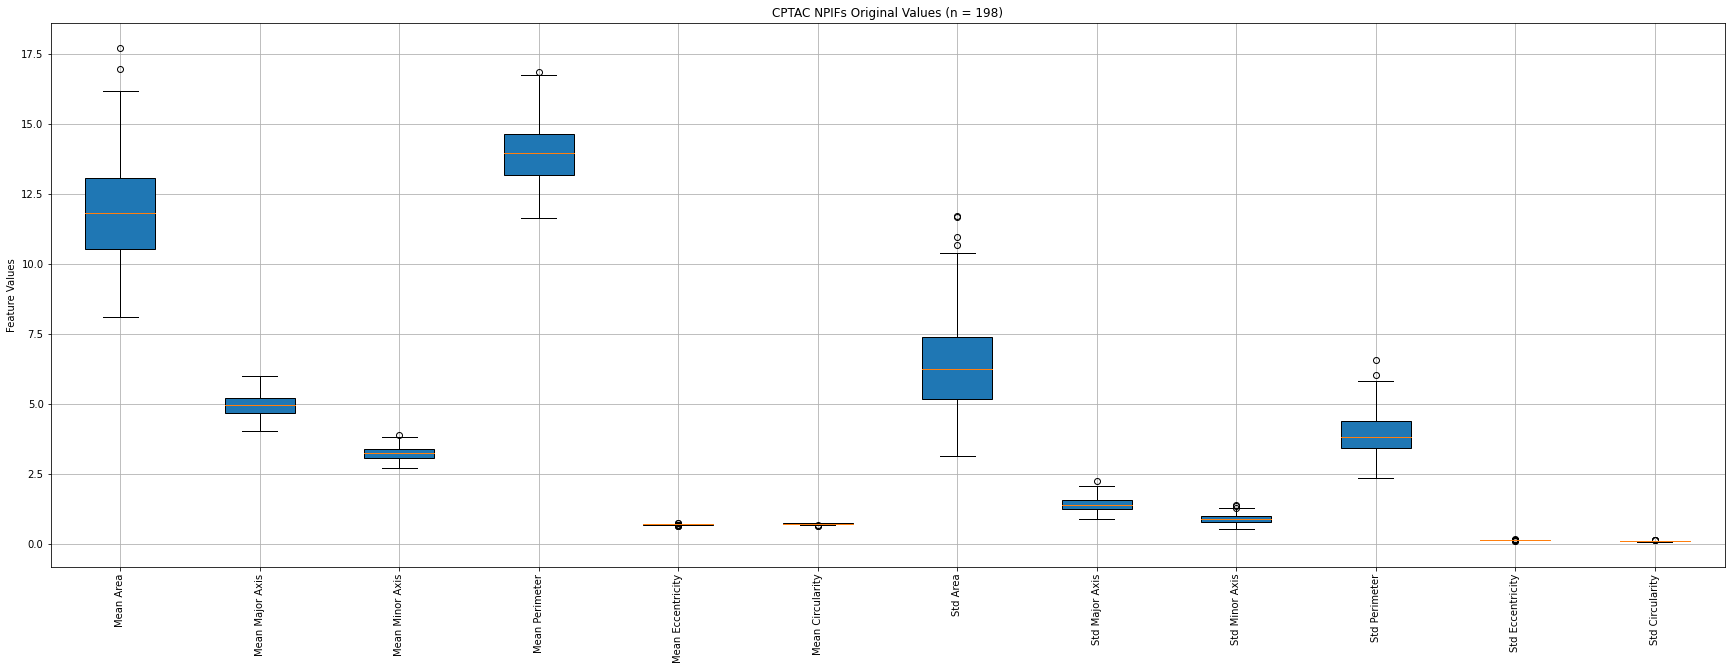

In [13]:
# Import required library
import matplotlib.pyplot as plt

# Select only NPIF features (excluding the first column 'Slide_Name')
cptac_features = patient_avg_df.iloc[:, 2:]

# Number of samples in the dataset
n_cptac = cptac_features.shape[0]

# Plot boxplots for PathAI NPIFs
plt.figure(figsize=(30, 10))
plt.boxplot(cptac_features.values, labels=cptac_features.columns, vert=True, patch_artist=True)
plt.xticks(rotation=90)
plt.title(f"CPTAC NPIFs Original Values (n = {n_cptac})")
plt.ylabel("Feature Values")
plt.grid(True)
plt.show()